## Harris 角点算法

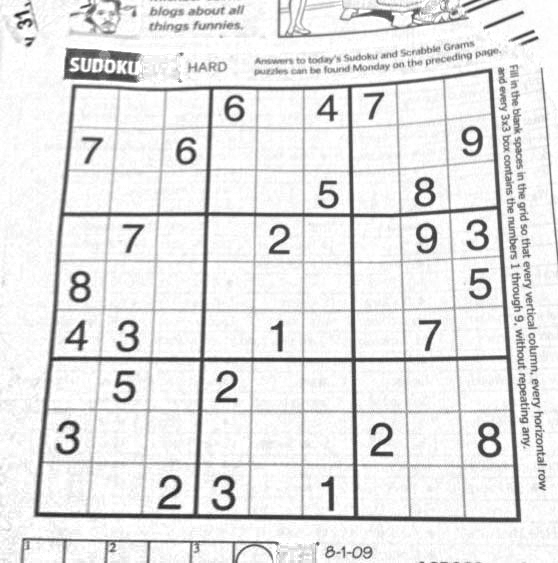

In [351]:
import os
from PIL import Image

# Specify the path to the image file
image_path = os.path.join(os.getcwd(), "images", "sudoku.png")
# Open the image using PIL
image = Image.open(image_path)

# Display the image
image


In [352]:
print("The size of the image is: {}".format(image.size))

The size of the image is: (558, 563)


In [353]:
import numpy as np
from scipy.ndimage.filters import convolve

def harris_corner_detector(image, k=0.04):
    # Convert the image to grayscale
    gray_image = image.convert("L")
    
    # Calculate the gradients using Sobel filters
    dx = np.gradient(gray_image, axis=1)
    dy = np.gradient(gray_image, axis=0)
    
    # Calculate the products of gradients
    dx2 = dx * dx
    dy2 = dy * dy
    dxy = dx * dy
    
    # Calculate the sums of gradients within a window
    window_size = 3
    sum_dx2 = convolve(dx2, np.ones((window_size, window_size)))
    sum_dy2 = convolve(dy2, np.ones((window_size, window_size)))
    sum_dxy = convolve(dxy, np.ones((window_size, window_size)))
    
    # Calculate the Harris response for each pixel
    det = sum_dx2 * sum_dy2 - sum_dxy**2
    trace = sum_dx2 + sum_dy2
    harris_response = det - k * trace**2
    corners = harris_response 
    
    return corners


Text(0.5, 1.0, 'Harris Corner Response')

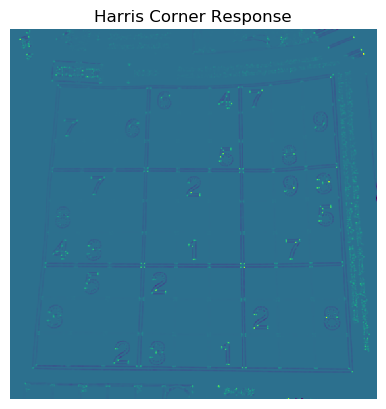

In [354]:
import matplotlib.pyplot as plt
# Compute Harris corner response
response = harris_corner_detector(image)




def Normalized_response(response):
    # 找到response的最小值和最大值
    min_val = np.min(response)
    max_val = np.max(response)
    
    # 对response进行线性归一化
    normalized_response = (response - min_val) / (max_val - min_val) * 255
    
    # 将归一化后的像素值取整
    normalized_response = normalized_response.astype(np.uint8)
    
    return normalized_response
'''
# 找到response的最小值和最大值
min_val = np.min(response)
max_val = np.max(response)

# 对response进行线性归一化
normalized_response = (response - min_val) / (max_val - min_val) * 255

# 将归一化后的像素值取整
normalized_response = normalized_response.astype(np.uint8)

# 现在，normalized_response中的像素值被归一化到0到255之间
'''
normalized_response = Normalized_response(response)
plt.imshow(normalized_response)
plt.axis('off')
plt.title('Harris Corner Response')


### 角点提取

In [355]:
#将normalized_response中的角点坐标提取出来
def get_corners(response, threshold=94):
    # Create a binary mask using the threshold
    mask = response > threshold
    # Find the indices of the pixels that are above the threshold
    corner_indices = np.argwhere(mask)
    return corner_indices

corners = get_corners(normalized_response, threshold=100)
print("Number of corners detected: {}".format(len(corners)))

Number of corners detected: 8154


### 角点标识

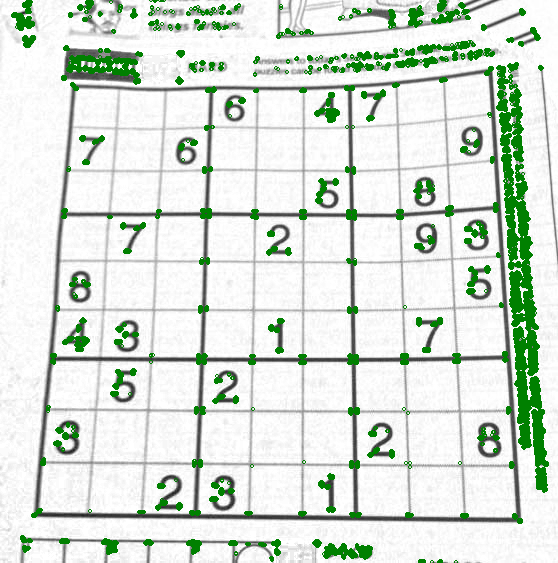

In [356]:
#将这些角点在原图中显示出来
def plot_corners(image, corners):
    # Create a copy of the image
    image_copy = image.copy()
    # Create a drawing object
    draw = ImageDraw.Draw(image_copy)
    # Draw a small circle at each corner
    for corner in corners:
        draw.ellipse((corner[1]-1.5, corner[0]-1.5, corner[1]+1.5, corner[0]+1.5), outline='green')
    return image_copy

from PIL import ImageDraw
image_with_corners = plot_corners(image, corners)
#image_with_corners.save('corners.png')
image_with_corners

## 关键点描述与匹配

In [357]:
# Specify the path to the image file
image_path_1 = os.path.join(os.getcwd(), "images", "uttower1.jpg")
image_path_2 = os.path.join(os.getcwd(), "images", "uttower2.jpg")
# Open the image using PIL
image_1 = Image.open(image_path_1)
image_2 = Image.open(image_path_2)


Number of corners detected in image 1: 2837


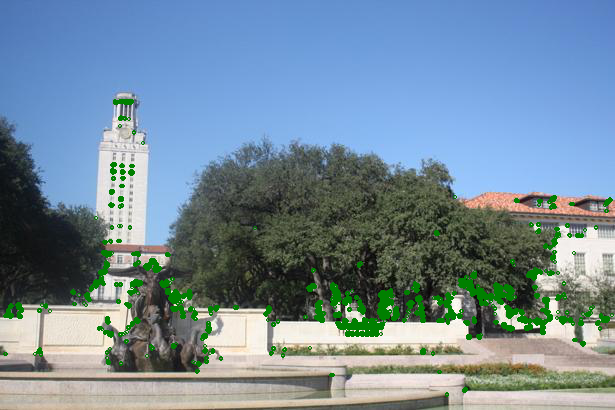

In [358]:
harris_response_1 = harris_corner_detector(image_1)

normalized_response_1 = Normalized_response(harris_response_1)
corners_1 = get_corners(normalized_response_1, threshold=45)
print("Number of corners detected in image 1: {}".format(len(corners_1)))
image_with_corners_1 = plot_corners(image_1, corners_1)
image_with_corners_1.save('corners_1.png')
image_with_corners_1

Number of corners detected in image 2: 4732


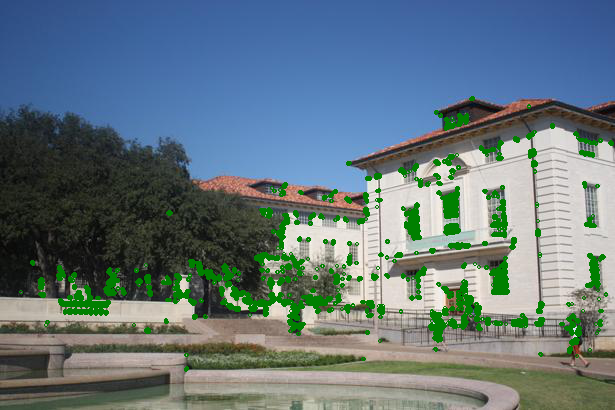

In [359]:
harris_response_2 = harris_corner_detector(image_2)
normalized_response_2 = Normalized_response(harris_response_2)
corners_2 = get_corners(normalized_response_2, threshold=55)
print("Number of corners detected in image 2: {}".format(len(corners_2)))
image_with_corners_2 = plot_corners(image_2, corners_2)
image_with_corners_2.save('corners_2.png')
image_with_corners_2

True

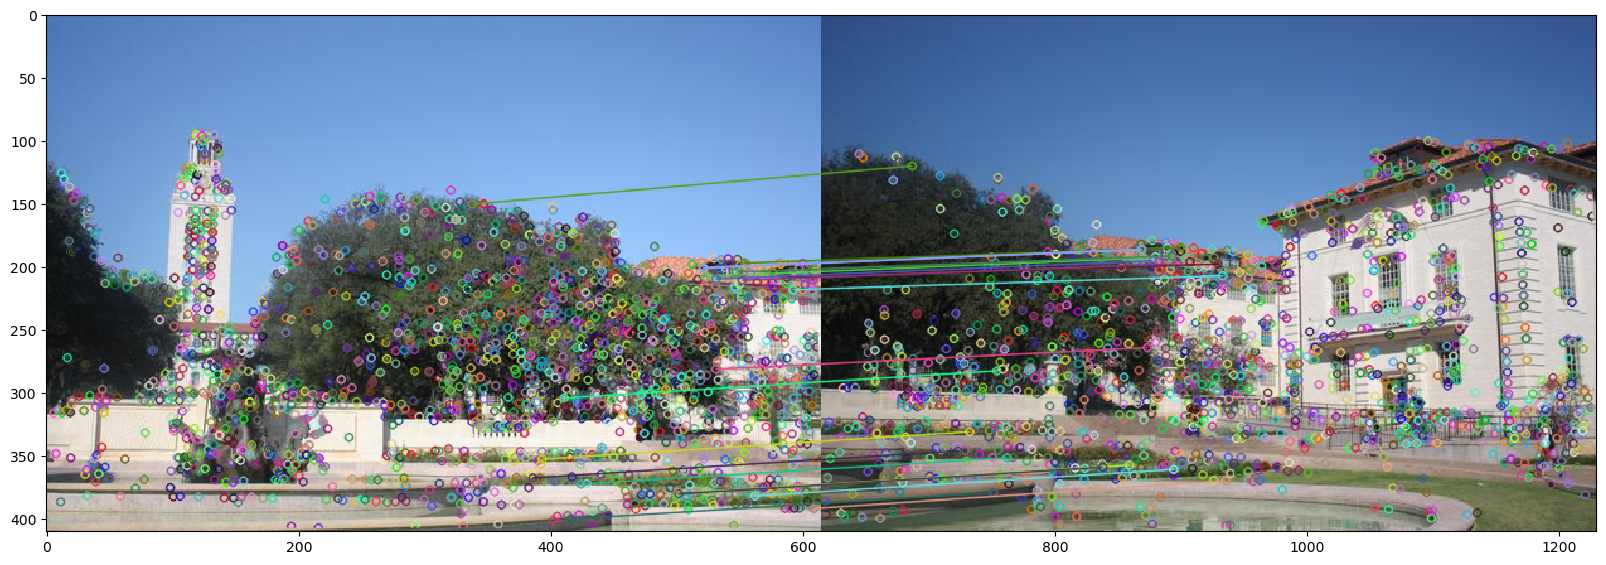

In [360]:
#用sift实现特征匹配
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Load the images
image_1 = cv2.imread(image_path_1)
image_2 = cv2.imread(image_path_2)

'''
# Convert the images to grayscale
gray_image_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2GRAY)
gray_image_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2GRAY)
'''

# Create a SIFT detector
sift = cv2.xfeatures2d.SIFT_create()

# Detect keypoints and descriptors in the images
keypoints_1, descriptors_1 = sift.detectAndCompute(image_1, None)
keypoints_2, descriptors_2 = sift.detectAndCompute(image_2, None)

# Create a Brute Force Matcher
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

# Match the descriptors
matches = bf.match(descriptors_1, descriptors_2)

# Sort the matches based on distance
matches = sorted(matches, key = lambda x:x.distance)

# Draw the matches
image_matches = cv2.drawMatches(image_1, keypoints_1, image_2, keypoints_2, matches[:20], None)

# Display the matches
plt.figure(figsize=(20, 10))
plt.imshow(cv2.cvtColor(image_matches, cv2.COLOR_BGR2RGB))

# Save the matches image
cv2.imwrite('SIFTmatches.png', image_matches)

In [361]:
keypoints_cor_1 = []
for kp in keypoints_1:
    y, x = kp.pt  # 获取关键点的坐标
    keypoints_cor_1.append([x, y])

In [362]:
#对keypoints_cor_1做四舍五入
keypoints_cor_1 = np.round(keypoints_cor_1).astype(np.int)
keypoints_cor_1 = np.array(keypoints_cor_1)

/Volumes/Data/anaconda/anaconda3/envs/hw8/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [363]:
keypoints_cor_2=[]
for kp in keypoints_2:
    y, x = kp.pt  # 获取关键点的坐标
    keypoints_cor_2.append([x, y])
keypoints_cor_2 = np.round(keypoints_cor_2).astype(np.int)
keypoints_cor_2 = np.array(keypoints_cor_2)


/Volumes/Data/anaconda/anaconda3/envs/hw8/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


In [364]:
matched_keypoints_indices = []
for match in matches:
    query_idx = match.queryIdx  # 查询图像中的关键点索引
    train_idx = match.trainIdx  # 训练图像中的关键点索引
    
    # 将查询图像和训练图像中匹配的关键点索引添加到检索对的列表中
    matched_keypoints_indices.append([query_idx, train_idx])

#转换成ndarray
matched_keypoints_indices = np.array(matched_keypoints_indices)

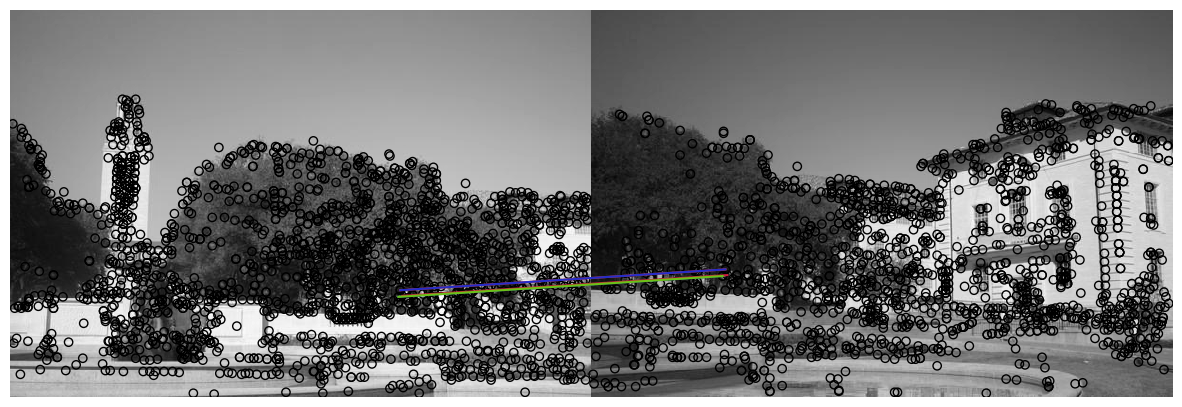

In [365]:
from host import ransac
from skimage.io import imread
from skimage.feature import plot_matches

H, robust_matches = ransac(keypoints_cor_1, keypoints_cor_2, matched_keypoints_indices,error_thresh=30)

#把img1和img2回复称彩色的
img1 = imread(image_path_1 , as_gray=True)
img2 = imread(image_path_2,  as_gray=True)

# Visualize robust matches
fig, ax = plt.subplots(1, 1, figsize=(15, 12))
plot_matches(ax, img1, img2, keypoints_cor_1, keypoints_cor_2, robust_matches)
plt.axis('off')
plt.show()


In [366]:
from host import get_output_space, warp_image



(410, 615)


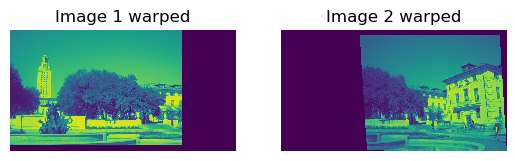

In [367]:
output_shape, offset = get_output_space(img1, [img2], [H])

# Warp images into output sapce
img1_warped = warp_image(img1, np.eye(3), output_shape, offset)
img1_mask = (img1_warped != -1) # Mask == 1 inside the image
img1_warped[~img1_mask] = 0     # Return background values to 0

img2_warped = warp_image(img2, H, output_shape, offset)
img2_mask = (img2_warped != -1) # Mask == 1 inside the image
img2_warped[~img2_mask] = 0     # Return background values to 0

# Plot warped images
plt.subplot(1,2,1)
plt.imshow(img1_warped)
plt.title('Image 1 warped')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img2_warped)
plt.title('Image 2 warped')
plt.axis('off')

plt.show()

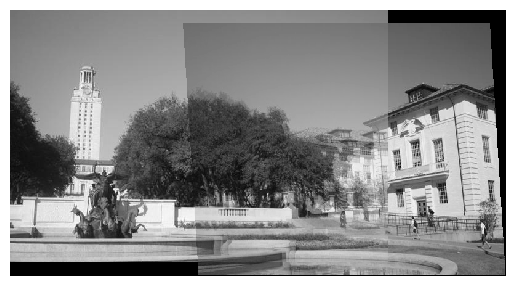

In [368]:
merged = img1_warped + img2_warped

# Track the overlap by adding the masks together
overlap = (img1_mask * 1.0 +  # Multiply by 1.0 for bool -> float conversion
           img2_mask)

# Normalize through division by `overlap` - but ensure the minimum is 1
normalized = merged / np.maximum(overlap, 1)
plt.imshow(normalized, cmap='gray')
plt.axis('off')
plt.show()